### Профиль Блазиуса

Реализуйте функцию расчета профиля Блазиуса

In [1]:
import scipy.integrate as scii
import numpy as np


def rhs(f, t):
    return np.array([f[1], f[2], -0.5*f[0]*f[2]])

#blasius profile
def getMesh_U_DuDy(N, y_max):
    # todo

### Вспомогательные процедуры

In [2]:
def boundary_layer_thickness(nu, u_e, x):
    return (nu*x/u_e)**0.5

def getRe_d(nu, u_e, d):
    return u_e*d/nu

def getDimensionalMesh_U_DuDy(x, u_e, nu, y_d, u_d, dudy_d):
    d = boundary_layer_thickness(nu, u_e, x)
    y = y_d*d
    u = u_d*u_e
    dudy = dudy_d*u_e/d
    return y, u, dudy

### Основные расчетные процедуры

In [3]:
from scipy.sparse import block_diag
import scipy.linalg as la

def get_y(j, y):
    return y[j]

def get_U(j, vels):
    return vels[j]

def get_dudy(j, grads):
    return grads[j]

def get_h(y):
    return y[1] - y[0]

# Functions to form matrix A and B from Spatial Eigenvalues problem Ax = alpha*Bx
def getE1():
    return np.array([[0, 0, 0],
                     [1, 0, 0],
                     [0, 1, 0]])

def getE2(nu):
    return np.array([[0, 1, 0],
                     [0, 0, 0],
                     [0, 0,-1/nu]])

def getE3(omega, nu, dudy):
    return np.array([[0, 0, 0],
                     [1j*omega/nu, -1/nu*dudy, 0],
                     [0, 1j*omega/nu, 0]])

def getInvE4(omega, nu, u):
    return la.inv(np.array([[-1j, 0, 0],
                       [1j/nu*u, 0, 1j/nu],
                       [0, 1j/nu*u, 0]]))

def getA_matrix(omega, nu, N, mesh, vels, grads, comp_num = 3):
    h = get_h(mesh)
    matrix_list = list()
    
    # Form first line of matrix A
    line = list()
    y = get_y(1, mesh)
    u = get_U(1, vels)
    dudy = get_dudy(1, grads)
    invE4 = getInvE4(omega, nu, u)
    E1 = invE4@getE1()
    E2 = invE4@getE2(nu)
    E3 = invE4@getE3(omega, nu, dudy)
    L2 = E3 - 2./h**2*E1
    line.append(L2)
    L3 = 1./h**2*E1 + 1./(2*h)*E2
    line.append(L3)
    for i in range(3,N):
        line.append(np.zeros((comp_num,comp_num)))
    matrix_list.append(line)

    # Form inner lines of matrix A
    for i in range(2, N-1):
        line = list()
        y = get_y(i, mesh)
        u = get_U(i, vels)
        dudy = get_dudy(i, grads)
        invE4 = getInvE4(omega, nu, u)
        E1 = invE4@getE1()
        E2 = invE4@getE2(nu)
        E3 = invE4@getE3(omega, nu, dudy)
        for j in range(1, N):
            if j==i-1:
                L1 = 1./h**2*E1 - 1./(2*h)*E2
                line.append(L1)
            elif j==i:
                L2 = E3 - 2./h**2*E1
                line.append(L2)
            elif j==i+1:
                L3 = 1./h**2*E1 + 1./(2*h)*E2
                line.append(L3)
            else:
                line.append(np.zeros((comp_num,comp_num)))
        matrix_list.append(line)

    # Form last line of matrix A
    line = list()
    for i in range(1, N-2):
        line.append(np.zeros((comp_num,comp_num)))
    
    y = get_y(N-1, mesh)
    u = get_U(N-1, vels)
    dudy = get_dudy(N-1, grads)
    invE4 = getInvE4(omega, nu, u)
    E1 = invE4@getE1()
    E2 = invE4@getE2(nu)
    E3 = invE4@getE3(omega, nu, dudy)
    L1 = 1./h**2*E1 - 1./(2*h)*E2
    line.append(L1)
    L2 = E3 - 2./h**2*E1
    line.append(L2)
    matrix_list.append(line)

    return np.bmat(matrix_list)

## Постановка задачи

In [4]:
def getTSmode(eigvals):
    ai_min = 0
    ar_min = 0
    for j in range(eigvals.size):
        ar = eigvals.real[j]
        ai = eigvals.imag[j]
        if  omega/u_e < ar and -150 < ai <= 0:
            if abs(ai) > abs(ai_min):
                ai_min = ai
                ar_min = ar
    return ai_min

def get_y_by_eta(eta, L, g):
    return eta*L/(g - eta)

def get_g(y_e, L):
    return 1 + L/y_e

L = 1.5/2
eta = np.linspace(0, 1, 25)
g = get_g(3/2, L)

In [5]:
mu = 1.85e-5
rho = 1.214
nu = mu/rho
u_e = 50

Re200: x = 0.012191103789126852


### Инкременты нарастания возмущения для разных omega

In [9]:
from progressbar import ProgressBar
from scipy.sparse.linalg import eigs

# mesh
N = 2000
y_d, u_d, dudy_d = getMesh_U_DuDy(N, 10)

pbar_omega = ProgressBar()
#x_mesh = np.linspace(0.05, 3, 10)
x_mesh = get_y_by_eta(eta, L, g)
x_mesh = x_mesh[1:]
omega_mesh = np.linspace(1000, 7000, 20)
ai_for_omega = []

#todo: распараллелить и посчитать на кластере
for omega in pbar_omega(omega_mesh):
    ai_s = []
    for x in x_mesh:
        y, u, dudy = getDimensionalMesh_U_DuDy(x, u_e, nu, y_d, u_d, dudy_d)
        A = getA_matrix(omega, nu, N, y, u, dudy)
        eigvals, eigvec = eigs(A, 100, sigma=2*omega/u_e, which='LM')
        ai = getTSmode(eigvals)
        ai_s.append(ai)
    ai_for_omega.append(ai_s)

[0.05454545 0.11320755 0.17647059 0.24489796 0.31914894 0.4
 0.48837209 0.58536585 0.69230769 0.81081081 0.94285714 1.09090909
 1.25806452 1.44827586 1.66666667 1.92       2.2173913  2.57142857
 3.        ]


100% |########################################################################|


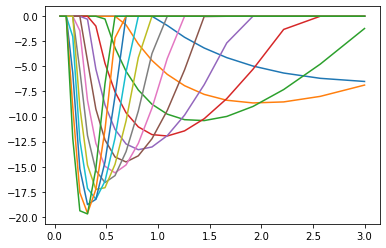

In [32]:
%matplotlib inline 
import matplotlib.pyplot as plt

for i in range(len(omega_mesh)):
    text = str(omega_mesh[i])
    plt.plot(x_mesh, ai_for_omega[i], label = text)
#plt.legend()

### Кривые усиления

In [26]:
def Nfactor(x, ai):
    Nom = np.zeros(x.size)
    h = x[0]
    Nom[0] = -h/2*(ai[0])
    for i in range(1, x.size):
        h = x[i] - x[i-1]
        Nom[i] = Nom[i-1] - h/2*(ai[i] + ai[i-1])
    return Nom

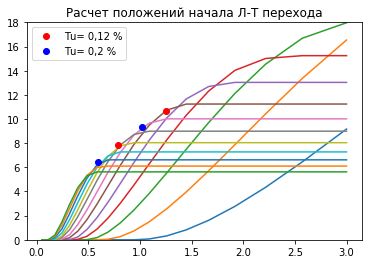

In [45]:
for i in range(len(omega_mesh)):
    spectrum = ai_for_omega[i]
    Nom = Nfactor(x_mesh, spectrum)
    plt.plot(x_mesh, Nom)

plt.plot(0.784, 7.82, 'ro', label = 'Tu= 0,12 %')
plt.plot(1.25, 10.7, 'ro')
plt.plot(0.597, 6.45, 'bo',  label = 'Tu= 0,2 %')
plt.plot(1.02, 9.32, 'bo')
plt.ylim(0, 18)
plt.legend()
name = 'Расчет положений начала Л-Т перехода'
plt.title(name)
filename = 'N_factors_subsonic_logos.png'
plt.savefig(filename)